# Zadanie nr 5 - metryki w przestrzeni napisów

In [113]:
from collections import Counter
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

## 1. Metryki

<i>Zaimplementuj przynajmniej 3 metryki spośród wymienionych: cosinusowa, LCS, DICE, euklidesowa.</i>

* LCS

In [2]:
def lcs(x, y):
    common = [[0 for _ in range(len(y)+1)] for _ in range(len(x)+1)]
    max_lcs = 0

    for i in range(1, len(x) + 1):
        for j in range(1, len(y)+1):
            common[i][j] = common[i-1][j-1] + 1 if x[i-1] == y[j-1] else 0
            max_lcs = max(max_lcs, common[i][j])

    return 1 - max_lcs/max(len(x), len(y))

#### ngramy

In [3]:
def ngrams(x, n):
    ngrams = [x[i:i+n] for i in range(len(x)-n+1)]
    return Counter(ngrams)

* Sorensena-Dice'a

In [4]:
def dice(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = set(ngrams(x, n).keys()), set(ngrams(y, n).keys())
    return 1 - 2*len(ngrams_x & ngrams_y)/(len(ngrams_x)+len(ngrams_y))

* euklidesowa

In [5]:
def euclides(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = ngrams(x, n), ngrams(y, n)

    keys = set(ngrams_x.keys()) | set(ngrams_y.keys())
    dist = sum((ngrams_x.get(key, 0) - ngrams_y.get(key, 0))**2 for key in keys) 
    len_x = sum(count**2 for key, count in ngrams_x.items())
    len_y = sum(count**2 for key, count in ngrams_y.items())

    return (dist/(len_x + len(y)))**0.5

* cosinusowa

In [6]:
def cosine(x, y, n=2):
    n = min([n, len(x), len(y)])
    ngrams_x, ngrams_y = ngrams(x, n), ngrams(y, n)
    dot = lambda n_x, n_y: sum(n_x[key]*n_y[key] for key in n_x.keys() & n_y.keys())
    return 1 - dot(ngrams_x, ngrams_y)/(dot(ngrams_x, ngrams_x)
                                        *dot(ngrams_y, ngrams_y))**0.5

* Levenshteina

In [7]:
def levenshtein(x, y):
    edit = [[None for _ in range(len(y) + 1)]
            for _ in range(len(x) + 1)]

    def delta(char_a, char_b): return 0 if char_a == char_b else 1

    for i in range(len(x) + 1):
        edit[i][0] = i

    for j in range(1, len(y) + 1):
        edit[0][j] = j

    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            edit[i][j] = min(edit[i-1][j] + 1, edit[i][j-1] + 1,
                       edit[i-1][j-1] + delta(x[i-1], y[j-1]))

    return edit[len(x)][len(y)]/max(len(x), len(y))

#### test metryk

Poniżej znajdują się przykładowe wartości poszczególnych metryk w trzech przypadkach dobranych tekstów. 

Wartości dla poszczególnych metryk często różnią się między sobą, jednak funkcje zostały zaimplementowane w taki sposób, aby wartości te były mniej więcej porównywalne. Dlatego w przypadku metryki Levenshteina, odległośc edycyjną podzieliłem przez maksymalną długość z obydwu tekstów, natomniast odległość euklidesową znormalizowałem przez sumę długości wektorów otrzymanych z liczby wystąpień poszczególnych ngramów. Dzięki temu dla każdej z metryk spełniony jest fakt, iż przyjmują one wartość 0 dla tożsamych napisów oraz wartość 1 dla zupełnie różniących się.

* podobne napisy

In [12]:
x = 'BCDF'
y = 'ABCDEF'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  0.5
dice:  0.5
euclides:  0.6666666666666666
cosine:  0.4836022205056778
levenshtein:  0.3333333333333333


* napisy zupełnie różne

In [13]:
x = 'BCDF'
y = 'A'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  1.0
dice:  1.0
euclides:  1.0
cosine:  1.0
levenshtein:  1.0


* napisy tożsame

In [14]:
x = 'BCDF'
y = 'BCDF'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('cosine: ', cosine(x, y))
print('levenshtein: ', levenshtein(x, y))

lcs:  0.0
dice:  0.0
euclides:  0.0
cosine:  0.0
levenshtein:  0.0


## 2. Sposoby oceny jakości klasteryzacji

<i>Zaimplementuj przynajmniej 2 sposoby oceny jakości klasteryzacji (np. indeks Daviesa-Bouldina).</i>

* indeks Daviesa-Bouldina

In [21]:
def average_distance_in_cluster(cluster, metric):
    sum_ = 0
    n = len(cluster)
    if n == 1:
        return 0
    
    for i, text_i in enumerate(cluster):
        for text_j in cluster[i+1:]:
                sum_ += metric(text_i, text_j)
                
    return sum_ /(n*(n-1)/2)

In [199]:
def davies_bouldin(clusters, metric):
    index = 0
    sigmas = [average_distance_in_cluster(cluster, metric) for cluster in clusters]
    
    for i, cluster_i in enumerate(clusters):
        max_ = 0
        for j, cluster_j in enumerate(clusters):
            if i == j: continue
            if cluster_distance(cluster_i, cluster_j, metric) == 0:
                print(cluster_i)
                print(cluster_j)
            max_ = max(max_, (sigmas[i] + sigmas[j])/cluster_distance(cluster_i, cluster_j, metric))
        index += max_
        
    return index/len(clusters)        

* indeks Dunna

In [24]:
def cluster_distance(cluster_a, cluster_b, metric):
    sum_ = 0
    
    return sum(metric(text_a, text_b) 
               for text_a in cluster_a 
               for text_b in cluster_b)/(len(cluster_a)
                                         *len(cluster_b))

def cluster_size(cluster, metric):
    if len(cluster) == 1: return 0
    return max(metric(text_i, text_j) for i, text_i in enumerate(cluster) for text_j in cluster[i+1:])

In [25]:
def dunn(clusters, metric):
    min_dist = min((cluster_distance(cluster_a, cluster_b, metric) \
                    for cluster_a in clusters \
                    for cluster_b in clusters \
                    if cluster_a != cluster_b))
    max_size = max((cluster_size(cluster, metric) \
                    for cluster in clusters))
    return min_dist/max_size

## 3. Stoplista

<i> Stwórz stoplistę najczęściej występujących słów. </i>

Stop listę tworzę dzieląc linijki na tokeny w postaci słów, a następnie znajdując najczęściej powtarzające się słowa we wszystkich linijkach.

In [30]:
def get_stop_words(lines, min_count):
    word_count = Counter(word for line in lines for word in line.split(' '))
    word_count = list(word_count.items())
    word_count.sort(key=lambda x: x[1], reverse=True)
    return [word for word, count in word_count if count >= min_count]

In [31]:
def remove_common(lines, num):
    stop_list = get_stop_words(lines, num)
    return [' '.join([word for word in line.split(' ') if word not in stop_list]) for line in lines], stop_list

## 4. Klasteryzacja

<i> Wykonaj klasteryzację zawartości załączonego pliku (lines.txt) przy użyciu przynajmniej 2 algorytmów oraz metryk zaimplementowanych w pkt. 1. i metryki Levenshteina. Każda linia to adres pocztowy firmy, różne sposoby zapisu tego samego adresu powinny się znaleźć w jednym klastrze. </i>

Do klasteryzacji używam funkcji DBSCAN z biblioteki sklearn.cluster.

In [214]:
def cluster(lines, metric):
    distances = [[metric(line_a, line_b) for line_a in lines] for line_b in lines]
    clustering = sklearn.cluster.DBSCAN(eps=0.8, min_samples=1).fit(distances)
    return clustering.labels_

## 5. Testy

<i> Porównaj jakość wyników sposobami zaimplementowanymi w pkt. 2. </i>

#### odczytanie danych testowych

Z uwagi na duży czas działania programu, korzystam tylko ze 100 linijek. Dzięki temu najwolniejsze metody nie działają dłużej niż minutę.

In [215]:
def get_example_lines(num):
    with open('lines.txt', 'r') as file:
        lines = list(file)
        
    lines = lines[:num]

    with open('clusters.txt', 'r') as file:
        clusters = list(file)
    
    correct_clustering = []
    cluster_num = 0
    
    for line in lines:
        cluster = 0
        for cluster_line in clusters:
            if cluster_line[0] == '#':
                cluster += 1
            elif cluster_line == line:
                correct_clustering.append(cluster)
                break
    
    return lines, np.array(correct_clustering)

In [216]:
def get_example_lines_clustered(num):
    lines = []
    current_cluster = 0
    
    with open('clusters.txt', 'r') as file:
        for line in file:
            if len(lines) == num: break
            if line.strip() == '': continue
            if line[0] == '#':
                current_cluster += 1
            else:
                lines.append((line, current_cluster))
    
    shuffle(lines)
    return [line[0] for line in lines], [line[1] for line in lines]

In [222]:
lines, correct_labels = get_example_lines_clustered(100)

#### testy krok po kroku

* klasteryzacja - znalezienie listy z indeksami klastrów poszczególnych linii danych:

In [223]:
labels = cluster(lines, cosine)

In [224]:
print(labels)

[ 0  1  2  3  4  5  6  7  8  9  6 10 11 12 13  6  6 14 15 16 17  6 18 11
 18 19 20 21 22  6 23  5 24 18 25 26 27  4 28 29 10 18  6  5 12 30 31 18
 32  2 10  0 33 34 35 36 37  9 31 38 39 32 11 31 40  5 18 18  9 41  5 31
 42 43 44  6  5 45  9  6 12 18  5 36 32 43 18 15 46  5  5 47  5 12 48  5
  5 18  6 49]


In [225]:
def renumber_labels(labels):
    seen = {}
    current = 0
    new_labels = []
    for label in labels:
        if label in seen:
            new_labels.append(seen[label])
        else:
            new_labels.append(current)
            seen[label] = current
            current += 1
    
    return np.array(new_labels)

In [226]:
print(renumber_labels(correct_labels))

[ 0  1  2  0  3  4  4  5  6  4  4  7  2  8  9  4  4 10  4  4 11  4 12  2
 13 14 15 16 17  4  4  4  4 18  9  4  4  3  4 17 19 18  4  4  8 13 13 13
 20 17  7 13 10  3 21 22  4 11 13 14  5 10  2 13  8  4 23 24  4  9  4 13
 22  4 13  4  4 10 25  4  8 12  4 22 20  4 18  4 26  4  4 27  4  8 22  4
  4 13  4  8]


* podzielenie linijek na klastry w postaci zbiorów

In [227]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [228]:
clusters = get_clusters_from_labels(lines, labels)

In [229]:
def print_clustering(clusters):
    for cluster in clusters:
        print('##########')
        for line in cluster:
            print(line)

In [230]:
print_clustering(clusters)

##########
TO ORDER OF ANTEY LTD

TO THE ORDER OF INTRANS LTD

##########
"Goldens" LLC

##########
FORTUM LTD

FORUM LTD

##########
ANTEY OOO SOPHISKAYA 52 ST PETERSBURG 192214 RUSSIA ST PETERSBURG RU

##########
REALCO LOGISTICS LTD. 4TH FLOOR,NO.10,LANE 345,YANGKUANG STREET,NEI HU TAIPEI,TAIWAN R.O.C.114

REALCO LOGISTICS LTDVDR 10 YANGKUANG STLANE 345 4F TAIWAN

##########
PANTOS LOGISTICS POLAND SP.    ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW, POLAND  TEL: 0048 22 358 2737  -ATTN: PRZEMEK HOJDA

PANTOS LOGISTICS POLAND SP.  ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW,POLAND  TEL: 0048 22 358 2737  - ATTN: PRZEMEK HOJDA

PANTOS LOGISTICS POLAND SP. ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW, POLAND TEL: 0048 22 358 2737  - ATTN: PRZEMEK HOJDA

PANTOS LOGISTICS POLLAND SP. Z.O.OUL SZYSKOWA 43 02-285 WARSAW, POLLAND TEL : +48 22 358 2750 FAX : +4822 358 2739

PANTOS LOGISTICS POLAND SP. Z O.O.UL. SZYSZKOWA 43 WARSZAWA, POLAND ZIP: 02-285 TEL : 0048 22 358 2750 ATTN: PIOTR PADUCH--

PANTOS LOGISTICS 

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

In [231]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, cosine))
print('\t          dunn index: ', dunn(clusters, cosine))

	davies-bouldin index:  0.5846553591310301
	          dunn index:  0.33861980647272577


#### wersja z zastosowaniem stoplisty 

* usunięcie słów ze stoplisty

In [234]:
lines_stop, common_words = remove_common(lines, 7)
print('removed words: ', common_words)

removed words:  ['LOGISTICS', 'PANTOS', '', 'OF', 'POLAND', 'CO.,LTD.', 'TO', 'ORDER', '358', 'THE', '22', 'O/B', 'SAME', 'AS', 'LTD\n', 'SP.', 'LTD', 'CO.,', ':', '43']


In [235]:
def show_differences(lines, lines_stop):
    for line, line_stop in zip(lines, lines_stop):
        if line != line_stop:
            print(line)
            print(line_stop, '\n')

* klasteryzacja

In [236]:
labels = cluster(lines_stop, cosine)

In [237]:
print(labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 12
 23 24 25 26 27 28 29  5 30 31 32 33 34  4 35 36 37 38 16  5 13 39 40 23
 41  2 11 42 43 44 45 46 47 48 49 50 51 52 12 49 53 54 31 55 56 32 54 57
 58 59 60 61 54 62 63 64 13 23 54 46 65 59 31 18 66 67 54 68  5 13 69  5
 54 31 70 71]


* podzielenie linijek na klastry w postaci zbiorów

In [238]:
clusters = get_clusters_from_labels(lines_stop, labels)

In [239]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [240]:
print_clustering(clusters)

##########
ANTEY
##########
"Goldens" LLC

##########
FORTUM
FORUM
##########
ANTEY OOO SOPHISKAYA 52 ST PETERSBURG 192214 RUSSIA ST PETERSBURG RU

##########
REALCO LTD. 4TH FLOOR,NO.10,LANE 345,YANGKUANG STREET,NEI HU TAIPEI,TAIWAN R.O.C.114

REALCO LTDVDR 10 YANGKUANG STLANE 345 4F TAIWAN

##########
ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW, TEL: 0048 2737 -ATTN: PRZEMEK HOJDA

ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW,POLAND TEL: 0048 2737 - ATTN: PRZEMEK HOJDA

ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW, TEL: 0048 2737 - ATTN: PRZEMEK HOJDA

SP.Z.O.O UL.SZYSZKOWA 43,02-285,WARSAW POLANDTEL:+0048 2737 ATTN:PRZEMEKHOJDA

SP.Z.O.O. UL.SZYSZKOWA 43,02-285,WARSAW, TEL: 0048 2737 ATTN:PRZEMEK HOJDA

##########
SSCP LTD.

##########
HAITIAN HUAYUAN (HONG KONG) LIMITEDUNIT 1105, 11/F, METROPLAZA TOWERII 223 HING FONG ROAD, KWAI FONG, N.T. HONG KONG

##########
CONSIGNEE TEL:48-58-690-00-00 FAX:48-58-690-0001

##########
LOGISTICS(CHINA) CO.,LTD.

##########
DONG YANG INDUSTRIAL LT D

##########
OOO NOVE

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

In [241]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, euclides))
print('\t          dunn index: ', dunn(clusters, euclides))

	davies-bouldin index:  0.9156323697334017
	          dunn index:  0.6998542122237651


Wyniki są bardzo porównywalne i w tym przypadku nie można powiedzieć, iż zastosowanie stop listy pomogło dokonać skutecznej klasteryzacji.

#### porównanie wyników dla różnych metryk

In [242]:
def test(lines, metric):
    print(metric.__name__)
    labels = cluster(lines, metric)
    clusters = get_clusters_from_labels(lines, labels)
    
    davies_index = davies_bouldin(clusters, metric)
    dunn_index = dunn(clusters, metric)
    print('\tdavies-bouldin index: ', davies_index)
    print('\t          dunn index: ', dunn_index)
    
    return davies_index, dunn_index

In [243]:
def compare_metrics(lines, metrics):
    davies_indices = []
    dunn_indices = []
    
    for metric in metrics:
        davies, dunn = test(lines, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
        
    lines_stop = remove_common(lines, 5)
    print('\n--with stoplist: ')
    
    for metric in metrics:
        davies, dunn = test(lines, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
    
    return davies_indices, dunn_indices

In [244]:
metrics = [dice, cosine, euclides, levenshtein, lcs]

In [245]:
davies_indices, dunn_indices = compare_metrics(lines, metrics)

dice
	davies-bouldin index:  0.6329626649136976
	          dunn index:  0.6363636363636364
cosine
	davies-bouldin index:  0.5846553591310301
	          dunn index:  0.33861980647272577
euclides
	davies-bouldin index:  0.6659032845022069
	          dunn index:  0.724202635966055
levenshtein
	davies-bouldin index:  0.6253617912593655
	          dunn index:  0.7445887445887445
lcs
	davies-bouldin index:  0.7416626723388757
	          dunn index:  0.8977272727272726

--with stoplist: 
dice
	davies-bouldin index:  0.6329626649136976
	          dunn index:  0.6363636363636364
cosine
	davies-bouldin index:  0.5846553591310301
	          dunn index:  0.33861980647272577
euclides
	davies-bouldin index:  0.6659032845022069
	          dunn index:  0.724202635966055
levenshtein
	davies-bouldin index:  0.6253617912593655
	          dunn index:  0.7445887445887445
lcs
	davies-bouldin index:  0.7416626723388757
	          dunn index:  0.8977272727272726


* wzorcowa klasteryzacja z pliku

In [246]:
correct_clusters = get_clusters_from_labels(lines, correct_labels)
print_clustering(correct_clusters)
davies_index = davies_bouldin(correct_clusters, cosine)
dunn_index = dunn(correct_clusters, cosine)

print('\tdavies-bouldin index: ', davies_index)
print('\t          dunn index: ', dunn_index)
correct_indices = [davies_index, dunn_index]

##########
TO ORDER OF ANTEY LTD

ANTEY OOO SOPHISKAYA 52 ST PETERSBURG 192214 RUSSIA ST PETERSBURG RU

##########
"Goldens" LLC

##########
FORTUM LTD

FORTUM LTD ADDRESS: NEPOKORENNYH PR. 11. LIT. "A", OFFICE 12N, ST. PETERSBURG, RUSSIA, 195220   TEL:7-8122441705

FORTUM LTD NEPOKORENNYH PR. 11,LIT."A", OFFICE 12 N, ST.PETERSBURG, RUSSIA,195220 TEL/FAX: + 7 812 232 1010

FORTUM LTD ADDRESS:NEPOKORENNYH PR.11,LIT."A ",OFFICE 12N,ST.PETERSBURG, RUSSIA,195220 INN 7804326502,++

##########
REALCO LOGISTICS LTD. 4TH FLOOR,NO.10,LANE 345,YANGKUANG STREET,NEI HU TAIPEI,TAIWAN R.O.C.114

REALCO LOGISTICS LTDVDR 10 YANGKUANG STLANE 345 4F TAIWAN

REALCO LOGISTICS(SHANGHAI) LTD

##########
PANTOS LOGISTICS POLAND SP.    ZO.OUL. SZYSZKOWA 43, 02-285, WARSAW, POLAND  TEL: 0048 22 358 2737  -ATTN: PRZEMEK HOJDA

PANTOS LOGISTICS CO.,LTD. O/B OF SSCP CO., LTD.

PANTOS LOGISTICS(CHINA) CO.,LTD.

PANTOS LOGISTICS CO.,LTD. O/B OF DONG YANG INDUSTRIAL CO., LT D

PANTOS LOGISTICS CO.,LTD. O/B OF LGELEC

* wykres

In [247]:
def plot_comparison(metrics, davies_indices, dunn_indices):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    
    metric_names = list(map(lambda x: x.__name__, metrics))
    
    ax[0][0].bar(metric_names, davies_indices[:len(metrics)], color='coral')
    ax[0][1].bar(metric_names, dunn_indices[:len(metrics)], color='darkblue')
    
    ax[0][0].set_title('davies-bouldin')
    ax[0][1].set_title('dunn')
    
    ax[1][0].bar(metric_names, davies_indices[len(metrics):], color='coral')
    ax[1][1].bar(metric_names, dunn_indices[:len(metrics):], color='darkblue')
    
    ax[1][0].set_title('davies-bouldin with stoplist')
    ax[1][1].set_title('dunn with stoplist')
    
    plt.show()

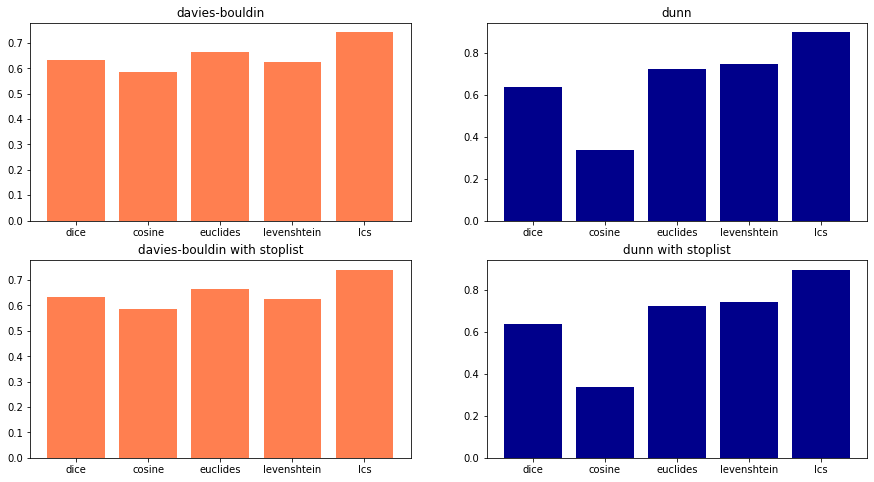

In [248]:
plot_comparison(metrics, davies_indices, dunn_indices)

Im większy indeks dunna, tym lepiej, natomiast w przypadku indeksu Daviesa-Bouldina zależność jest odwrotna.

<i>Czy masz jakiś pomysł na poprawę jakości klasteryzacji w tym zadaniu? </i>

* Przeprowadzenie preprocessing linijek. Usunięcię niepotrzebnych białych znaków, cudzysłowów, kropek itd.
* Lepsze dobranie parametrów modelu.

## Wnioski

- Skuteczność klasyfikacji zależy od doboru metryki, jak również dobranych do niej parametrów.

- Skuteczność klasteryzacji można zwiększyć stosując stoplistę najczęściej występujących elementów, jednak nie w każdym przypadku ma to sens, zależy to od rodzaju danych z jakimi mamy do czynienia

M. Hawryluk 20.05.2021